### Imports and Setup

In [17]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import copy

# sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# modAL
from modAL.disagreement import max_std_sampling
from modAL.models import ActiveLearner, CommitteeRegressor

# scipy
from scipy import sparse

# from sklearn import preprocessing
# from sklearn.utils import shuffle
# from modAL.models import BayesianOptimizer, 
# from modAL.acquisition import max_EI

# custom package
from packages.activelearning import activelearning as al


### Set random seed
seed = 5
random.seed(seed)
np.random.seed(seed)

### Suppresses Warning
import warnings
warnings.filterwarnings('ignore')

# 1.1. Data Load (5 points)
**In this question, you need to build a regression model with active learning for predicting binding affinity between MHC class I and small peptides. The dataset is provided in file `hw3_data.csv`.**

**TODO**
- **Read the data into the jupyter notebook. Columns 2 and 3 in the dataset file correspond to peptide sequences and pIC50 values.**

### Load Data

In [4]:
data = pd.read_csv('data/hw3_data.csv', delimiter=',',header=0)
print(data.shape)
data.head(5)

(9051, 4)


,id,allele,seq,pIC50
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0
1,seq1,HLA-A*02:01,AIYDTMQYV,9.0
2,seq2,HLA-A*02:01,ALATFTVNI,9.0
3,seq3,HLA-A*02:01,ALDEGLLPV,9.0
4,seq4,HLA-A*02:01,ALFPIIWAL,9.0


# 1.2. Encode Data (10 points)
**Since we are dealing with machine learning models, you need to convert peptide sequences into feature vectors. The simplest way to do this is to use a one-hot encoding.**

**Each character in the amino acid alphabet will correspond to a binary vector with a single 1 and all zeros. The size of the vector is equal to the size of the amino acid alphabet. The position of 1 encodes a specific amino acid. The resulting feature vector for a peptide is a concatenation of the feature vectors of its amino acids. Since we are dealing with 9-mers here, the size of the feature vector for a peptide should be equal to 9*(size of the amino acid alphabet).**

**TODO**
- **Encode the data.**
- **Split data into train and test datasets.**

### Encode Data
I want to keep some notion of the order of the amino acids. The 3D structure they form is vital for predicting binding quality. One possible way is to group letters in order. How do I decide how many letters constitutes a group?

Ex: 3-mers
```
AIIDYIAYM
AII
 IID
  IDY
    ...
      AYM
```

3-mers results in N < J, where N is the number of samples and J is the number of features. If we want to use multivariate regression, we'll need to use ridge regression or some other sparse form.

In [5]:
data['seq'].str.len().unique()  # every seq is length 9

array([9])

In [6]:
# create separate columns for each amino acid
for i in range(9):
    colname='seq'+str(i)
    data[colname] = [x[i] for x in data['seq']]

In [7]:
data.head(1)

,id,allele,seq,pIC50,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0,A,I,I,D,Y,I,A,Y,M


In [8]:
# number of unique letters
len(data['seq0'].unique())

20

In [9]:
# # create triplets
# k = 3
# count = 9-k+1
# start=0
# end=k
# for i in range(count):
#     colname='triplet'+str(i)
#     data[colname] = [x[start:end] for x in data['seq']]
#     start +=1
#     end +=1

In [10]:
data.head(1)

,id,allele,seq,pIC50,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0,A,I,I,D,Y,I,A,Y,M


In [11]:
X_df = data.drop(['pIC50','id','allele', 'seq'],axis=1)
y = data['pIC50']
print(X_df.shape)
print(y.shape)

(9051, 9)
(9051,)


In [12]:
X_df.head(1)

,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,A,I,I,D,Y,I,A,Y,M


In [13]:
enc = OneHotEncoder(handle_unknown='ignore')
X_enc = enc.fit_transform(X_df)
print(type(X_enc))
print(X_enc.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(9051, 180)


In [14]:
# convert to numpy array
X_pool=sparse.csr_matrix.toarray(X_enc)
print(type(X_pool))
print(X_pool.shape)
y_pool = y.to_numpy()
print(y_pool.shape)

<class 'numpy.ndarray'>
(9051, 180)
(9051,)


### Split Data
- ~~X_initial: set of samples removed from data pool for initialization~~
- X_train: 2/3 of data pool
- X_test: 1/3 of data pool

In [15]:
#?? initial training set for active learners?
# n_initial = 10

# # select random instances to use as initial active learning training set
# idx_initial = np.random.choice(X_np.shape[0], n_initial)
# X_initial = X_np[idx_initial]
# y_initial = y_np[idx_initial]
# print(X_initial.shape)
# print(y_initial.shape)


# # remove from pool of data for testing and training
# X_pool = np.delete(X_np, idx_initial, axis=0)
# y_pool = np.delete(y_np, idx_initial, axis=0)
# print(X_pool.shape)
# print(y_pool.shape)


# split remaining pool of data
X_train, X_test, y_train, y_test = train_test_split(X_pool, y_pool, test_size=0.33)
print()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



(6064, 180)
(6064,)
(2987, 180)
(2987,)


# 1.3. Build Active Learning  model (20 points)
**Now you can start building the model with active learning! We do not give you any specific instructions as to which algorithm to implement. You can use something similar to [this](https://modal-python.readthedocs.io/en/latest/content/examples/active_regression.html) example in modAL documentation, or query-by-committee when a label is requested for samples which the committee is least confident about or anything else covered in the lectures.**

**TODO**
- **Implement an active learning algorithm using modAL.**

### Run Model

In [ ]:
%%time

# make a copy of the data for use in this section
X_pool_comm = copy.deepcopy(X_train)
y_pool_comm = copy.deepcopy(y_train)

# build active learner
kernel = RBF(length_scale=0.5,length_scale_bounds=(1e-2, 1e3))
n_learner = 10
n_initial = 80
committee = al.build_committee(kernel, n_learner, n_initial, X_pool_comm, y_pool_comm, seed)

# perform active learning
n_queries = 400
history_comm = al.run_and_score_active_learner_regression(committee, X_pool_comm, y_pool_comm, X_test, y_test, n_queries)


# 1.4. Score model (5 points)
**The quality of the model should be measured on the test set as $R^2$ score. The minimum acceptable $R^2$ score is 0.6.**

**TODO**
- **Score the model on the test set using $R^2$.**

In [ ]:
# score the final model
r2 = al.score_regression_model(committee, X_test,y_test)
print("R2 for test set",r2)


# compare against R2 of the remaining pool
r2_pool = al.score_regression_model(committee, X_pool_comm,y_pool_comm)
print("R2 for pool",r2_pool)

# 1.5. Compare with Random Active Learner (5 points)
**TODO**
- **Compare your results with no active learning scheme by training a random forest regressor on the same amount of data points, but selected randomly. (An active learner with a random query strategy.)**

In [24]:
class RfWrapper(RandomForestRegressor):  # superclass
    def predict(self, X, return_std = False):
        if return_std:
            ys = np.array([e.predict(X) for e in self.estimators_])
            return np.mean(ys, axis = 0).ravel(), np.std(ys, axis = 0).ravel()
        return super().predict(X).ravel()

In [25]:
def random_query(learner, X):
   
    n_samples = len(X)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X[query_idx]

### Run random active learner

In [28]:
%%time

# copy data for this section
X_pool_rand = copy.deepcopy(X_train)
y_pool_rand = copy.deepcopy(y_train)


# use the same initialization to make comparison meaningful
n_initial = 80
initial_idx = []
for i in range(1):
    initial_idx.append(np.random.choice(len(X_pool_rand), size=n_initial, replace=False))
initial_rand = initial_idx[0]

regressor = ActiveLearner(
    estimator=RfWrapper(n_estimators = 20, max_depth = 6, random_state = seed),
    query_strategy=random_query,
    X_training=X_pool_rand[initial_rand], 
    y_training=y_pool_rand[initial_rand]
)


# run learner
n_queries = 200
history_rand = al.run_and_score_active_learner_regression(regressor, X_pool_rand, y_pool_rand, X_test, y_test, n_queries)


CPU times: user 7.48 s, sys: 152 ms, total: 7.64 s
Wall time: 7.71 s


### Score random active learner

In [29]:
# score the final model

r2=al.score_regression_model(regressor, X_test,y_test)
print("R2 for test set",r2)

# compare against R2 of the remaining pool
r2_pool=al.score_regression_model(regressor, X_pool_rand,y_pool_rand)
print("R2 for pool",r2_pool)

R2 for test set 0.34454847464507854
R2 for pool 0.3896585954621048


### Compare against strategic active learner

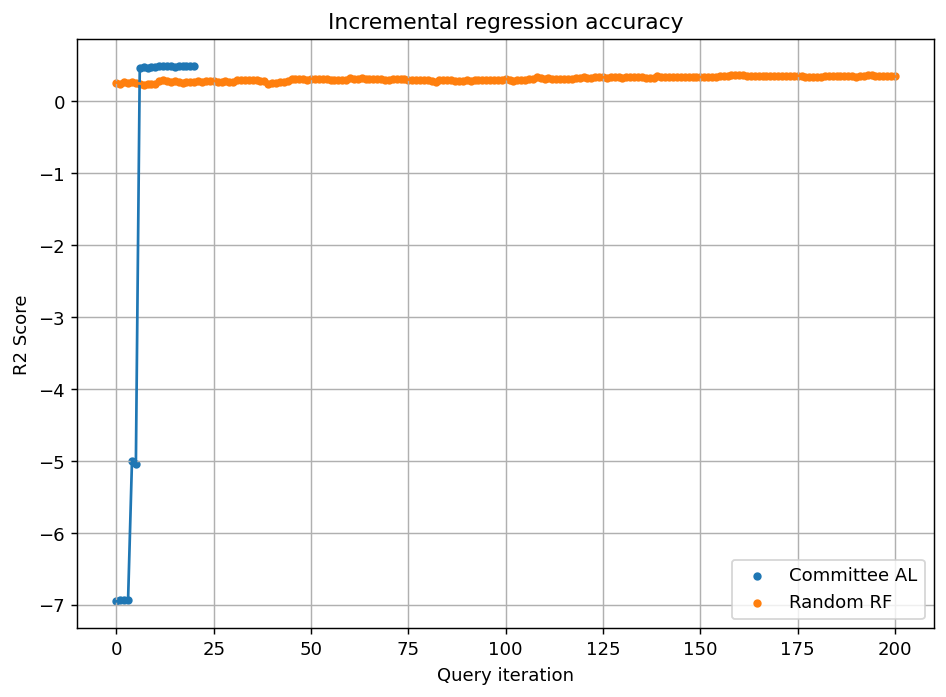

In [33]:
# compare the two results
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_comm)
ax.scatter(range(len(history_comm)), history_comm, s=13, label = 'Committee AL')

ax.plot(history_rand)
ax.scatter(range(len(history_rand)), history_rand, s=13, label = 'Random RF')

ax.grid(True)

ax.set_title('Incremental regression accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('R2 Score')
# axes.set_ylim([0,1])

ax.legend()
plt.show()

# 1.6. Summary (5 points)
**TODO**
- **Write a paragraph about your method, describe your observations and difficulties.**

### Method
- Consider encoding sequence k-mers together because order of sequence is important too. This controls protein shape, which should strongly affect binding. Worried about N < J.
- Tried various regressors: Ridge, Random Forest, Gaussian Process. GP did the best on the entire training set, with Ridge being a close second.
- Grid search varying kernel, number of learners in Committee, and initial training size
- Run grid parameters through linear regression to determine regression coefficients and figure out importance of each parameter
- Importance of changing only one hyperparameter at a time. Need enough data to determine trends due to tuning, given everything else is held constant.


### Difficulties
- understanding kernel in Gaussian process (which to use)
- understanding what to modify to improve R2 values. Is it the encoding? Is it the number of committee members? Is it the query strategy? Is it the hyperparmeters or kernel for the regressor?
- Rerunning cells messes up R2 value. Goes from 0.3 to -0.01.
- understanding range of hyperparameters like length_scale for kernels
- testing takes time (3-6 min per iteration, can run for 6 hours testing 120 configurations)
- testing on half the query size (100) takes long time, hard to determine whether smaller values will predict trajectory of larger results (does better model at 1/2 the data result in better model at full data?)


### Observations
#### Grid Search 1
- `n_learners`: More committee members is better (20 outperforms 2,5,10 when all other hyperparameters are held constant). Positive correlation.
- `n_initial`: Larger initial training set is better (80 outperforms 10,20,40). Positive correlation.
- `scale_length`: seems to have slightly negative correlation (larger values result in smaller r2). Overall, barely an effect with Matern kernel.


#### Final
- AL is better than random eventually
- after about 100 queries, AL remains better